In [1]:
!pip install pyconll

# Libraries

In [2]:
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile
# from collections.abc import Iterable
from pyconll import load_from_string
import numpy as np
from scipy.sparse import hstack, vstack
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import FastText
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, learning_curve, cross_val_score
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, BatchNormalization, Dropout, Input, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# from keras.utils import np_utils
from keras import utils
# from sklearn.metrics.classification import UndefinedMetricWarning
# warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from sklearn.metrics import classification_report
from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Downloading Files

In [5]:
UD_ENGLISH_TRAIN = 'en_partut-ud-train.conllu'
UD_ENGLISH_DEV = 'en_partut-ud-dev.conllu'
UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

[dataset repo containing statistics](https://github.com/UniversalDependencies/UD_English-ParTUT/tree/master)

In [6]:
def download_files():
    print('Downloading English treebank...')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/UniversalDependencies/UD_English-ParTUT/master/en_partut-ud-dev.conllu', 'en_partut-ud-dev.conllu')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/UniversalDependencies/UD_English-ParTUT/master/en_partut-ud-test.conllu', 'en_partut-ud-test.conllu')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/UniversalDependencies/UD_English-ParTUT/master/en_partut-ud-train.conllu', 'en_partut-ud-train.conllu')
    print('Treebank downloaded.')
    print('Downloading Fasttext pre-trained word embeddings...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec.zip')
    print('Pre-trained word embeddings downloaded.')
    print('Extracting zip file...')
    zip_ref = zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Zip file extracted.')

`check reachability of the host`

In [7]:
import urllib.request

url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" # Replace with your URL
try:
    response = urllib.request.urlopen(url)
    # Your code to handle the successful response goes here
except Exception as e:
    print(f"Error: {e}")

In [8]:
download_files()

Treebank downloaded.
Pre-trained word embeddings downloaded.
Extracting zip file...
Zip file extracted.


## Preprocessing

In [9]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [10]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

```python
for sentence in sentences:
    for token in sentence:
        print(token.form, token.upos, token.xpos, token.feats, token.head, token.deps, token.misc)
        

In [11]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in train set:  1781
Tagged words in train set: 43503
Tagged sentences in dev set:  156
Tagged words in dev set: 2722
Tagged sentences in test set:  153
Tagged words in test set: 3408


In [12]:
print(train_sentences[0])

[('distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]


In [13]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

In [14]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

Number of terms not found in train set: 286


### Load pre-trained word embeddings
We use fasttext wiki-news vectors to build a dictionary with word as key and its vector as value

In [15]:
embs_path = 'wiki-news-300d-1M.vec'
embeddings = KeyedVectors.load_word2vec_format(embs_path, binary=False)
print(embeddings.vectors.shape)

(999994, 300)


In [16]:
# w2c = dict()
# for item in embeddings.vocab:
#     w2c[item]=embeddings.vocab[item].count

w2c = dict()
for item in embeddings.key_to_index:
    w2c[item] = embeddings.key_to_index[item]

In [17]:
w2c = dict()
for item in embeddings.key_to_index:
    count = embeddings.get_vecattr(item, "count")
    w2c[item] = count

##### 10 most frequent terms

In [18]:
dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True)[:10])

{',': 999994,
 'the': 999993,
 '.': 999992,
 'and': 999991,
 'of': 999990,
 'to': 999989,
 'in': 999988,
 'a': 999987,
 '"': 999986,
 ':': 999985}

## Extracting the Features

In [19]:
dim = embeddings.vectors.shape[1]
pad = np.zeros(dim) # Pad vector
np.random.seed(3) # For reproducibility
oov =  np.random.uniform(-0.25, 0.25, dim) # Out-of-vocabulary vector

def features_embs(sentence, index, window=1, method='concat'):
    """ sentence: [w1, w2, ...],
        index: the index of the word,
        window: number of places left and right of the classified word,
        method: sum or concatenate the vectors of words in the window """
    unknown = 0
    if method == 'sum':
        vec = np.array(dim)
        for i in range(index-window,index+window+1):
            if i<0:
                vec = np.sum([vec, pad], axis=0)
                continue
            if i>len(sentence)-1:
                vec = np.sum([vec, pad], axis=0)
                continue
            try:
                vec = np.sum([vec, embeddings[sentence[i]]], axis=0)
            except:
                vec = np.sum([vec, oov], axis=0)
                unknown +=1

    if method == 'concat':
        vec = np.array([])
        for i in range(index-window,index+window+1):
            if i<0:
                vec = np.append(vec, pad) #for word indices out of sentence bounds (begin), append pad vector
                continue
            if i>len(sentence)-1:
                vec = np.append(vec, pad) #for word indices out of sentence bounds (end), append pad vector
                continue
            try:
                vec = np.append(vec, embeddings[sentence[i]])
            except:
                vec = np.append(vec, oov) #if word is not in embedding model append the oov vector
                unknown +=1

    return vec, unknown

In [20]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In [21]:
def transform_to_dataset(tagged_sentences, window):
    i=0
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index),\
                      features_embs(untag(tagged), index, window)[0],\
                     ])
            y.append(tagged[index][1])
            #features_embs(untag(tagged), index, window)[1]
            k = features_embs(untag(tagged), index, window)[1]
            i += k
    return X, y, i

In [22]:
def transform_test_sentence(sentence, window):
    X = []
    for index in range(len(sentence)):
            X.append([
                      features_basic(sentence, index),\
                      features_embs(sentence, index, window),\
                     ])
    return X

tests

In [23]:
untag(test_sentences[1])

['any',
 'use',
 'of',
 'the',
 'work',
 'other',
 'than',
 'as',
 'authorized',
 'under',
 'this',
 'license',
 'or',
 'copyright',
 'law',
 'is',
 'prohibited',
 '.']

In [24]:
test_sentence = ['The', 'only', 'way', 'is', 'forward', '!']

In [25]:
print('Shape of vector at index 0 of test_sentence for window size 1:',len(features_embs(test_sentence, 0, window=1, method='concat')[0]))
print('Shape of vector at index 3 of test_sentence for window size 2:',len(features_embs(test_sentence, 0, window=2, method='concat')[0]))

Shape of vector at index 0 of test_sentence for window size 1: 900
Shape of vector at index 3 of test_sentence for window size 2: 1500


In [26]:
print(features_embs(test_sentence, 0, 1)[0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [27]:
def vectorize(train, val, test, window=1, method='embs'):
    """
    method can be one of three options:
        'embs': window embeddings
        'classical': dictionary of features depending on the sentence where the term has been extracted from
        'boosted': combination of embs and classical
    """

    if method=='embs':
        print('Embeddings window method')
        print('Vectorizing Dataset...')
        print('Vectorizing train...')
        X_train, y_train, unk_tr = transform_to_dataset(train, window=window)
        X_train = [x[1] for x in X_train]
        X_train = np.asarray(X_train)

        print('Vectorizing validation...')
        X_val, y_val, unk_val = transform_to_dataset(val, window=window)
        X_val = [x[1] for x in X_val]
        X_val = np.asarray(X_val)

        print('Vectorizing test...')
        X_test, y_test, unk_te = transform_to_dataset(test, window=window)
        X_test = [x[1] for x in X_test]
        X_test = np.asarray(X_test)

        print('Dataset vectorized.')
        print('Train shape:', X_train.shape)
        print('Validation shape:', X_val.shape)
        print('Test shape:', X_test.shape)
        print('Found %s unknown words in train set %s unknown words in validation set and %s unknown words in test set' % (unk_tr, unk_val, unk_te))
        return X_train, y_train, X_val, y_val, X_test, y_test

    if method=='classical':
        print('Classical method')
        print('Vectorizing Dataset...')
        print('Vectorizing train...')
        X_train, y_train, _ = transform_to_dataset(train, window=window)
        v = DictVectorizer(sparse=True)
        X_train = v.fit_transform([x[0] for x in X_train])

        print('Vectorizing validation...')
        X_val, y_val, _ = transform_to_dataset(val, window=window)
        X_val = v.transform([x[0] for x in X_val])

        print('Vectorizing test...')
        X_test, y_test, _ = transform_to_dataset(test, window=window)
        X_test = v.transform([x[0] for x in X_test])

        print('Dataset vectorized.')
        print('Train shape:', X_train.shape)
        print('Validation shape:', X_val.shape)
        print('Test shape:', X_test.shape)
        X_train = X_train # Because we have sparce matrix
        X_val = X_val # Because we have sparce matrix
        X_test = X_test # Because we have sparce matrix
        return X_train, y_train, X_val, y_val, X_test, y_test, v

    if method=='boosted':
        print('Combined Classical - Embeddings window method')
        print('Vectorizing Dataset...')
        print('Vectorizing train...')
        X_train, y_train, unk_tr = transform_to_dataset(train, window=window)
        v = DictVectorizer(sparse=True) # We choose sparse=True for faster concatenation later
        X_classical = v.fit_transform([x[0] for x in X_train])
        X_embs = [x[1] for x in X_train]
        X_embs = np.asarray(X_embs)
        X_train = hstack((X_classical, X_embs))
        del X_classical, X_embs

        print('Vectorizing validation...')
        X_val, y_val, unk_val = transform_to_dataset(val, window=window)
        X_classical_val = v.transform([x[0] for x in X_val])
        X_embs_val = [x[1] for x in X_val]
        X_embs_val = np.asarray(X_embs_val)
        X_val = hstack((X_classical_val, X_embs_val)) # We concatenate the feature vectors

        print('Vectorizing test...')
        X_test, y_test, unk_te = transform_to_dataset(test, window=window)
        X_classical_test = v.transform([x[0] for x in X_test])
        X_embs_test = [x[1] for x in X_test]
        X_embs_test = np.asarray(X_embs_test)
        X_test = hstack((X_classical_test, X_embs_test)) # We concatenate the feature vectors

        print('Dataset vectorized.')
        print('Train shape:', X_train.shape)
        print('Validation shape:', X_val.shape)
        print('Test shape:', X_test.shape)
        del X_classical_test, X_embs_test
        print('Found %s unknown words in train set %s unknown words in validation set and %s unknown words in test set' % (unk_tr, unk_val, unk_te))
        X_train = X_train.tocsr() # Because we have sparce matrix
        X_val = X_val.tocsr() # Because we have sparce matrix
        X_test = X_test.tocsr() # Because we have sparce matrix
        gc.collect()
        return X_train, y_train, X_val, y_val, X_test, y_test, v

### Using a basic unigram as baseline

In [28]:
default_tagger = nltk.DefaultTagger('NN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [29]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [30]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [31]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.accuracy(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.8603
f1-macro score: 0.8266


In [32]:
print(classification_report(y_test, y_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

         ADJ     0.8832    0.7803    0.8286       223
         ADP     0.9452    0.8832    0.9131       488
         ADV     0.9057    0.7500    0.8205       128
         AUX     0.9286    1.0000    0.9630       234
       CCONJ     1.0000    0.9896    0.9948        96
         DET     0.9661    0.9749    0.9705       439
        INTJ     1.0000    1.0000    1.0000         2
          NN     0.0000    1.0000    0.0000         0
        NOUN     0.9549    0.8143    0.8790       754
         NUM     0.9649    0.9016    0.9322        61
        PART     0.5323    1.0000    0.6947        66
        PRON     0.9333    0.7706    0.8442       109
       PROPN     0.8676    0.6556    0.7468        90
       PUNCT     1.0000    1.0000    1.0000       339
       SCONJ     0.6863    0.6863    0.6863        51
        VERB     0.9316    0.6687    0.7786       326
           X     1.0000    1.0000    1.0000         2

    accuracy              

In [33]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [34]:
check_tagger(test_sentences[1])

('any', 'DET') DET 
('use', 'NOUN') NOUN 
('of', 'ADP') ADP 
('the', 'DET') DET 
('work', 'NOUN') NOUN 
('other', 'ADJ') ADJ 
('than', 'ADP') SCONJ <<--- Error!
('as', 'ADP') ADP 
('authorized', 'NN') VERB <<--- Error!
('under', 'ADP') ADP 
('this', 'DET') DET 
('license', 'NOUN') NOUN 
('or', 'CCONJ') CCONJ 
('copyright', 'NOUN') NOUN 
('law', 'NOUN') NOUN 
('is', 'AUX') AUX 
('prohibited', 'VERB') VERB 
('.', 'PUNCT') PUNCT 


In [35]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

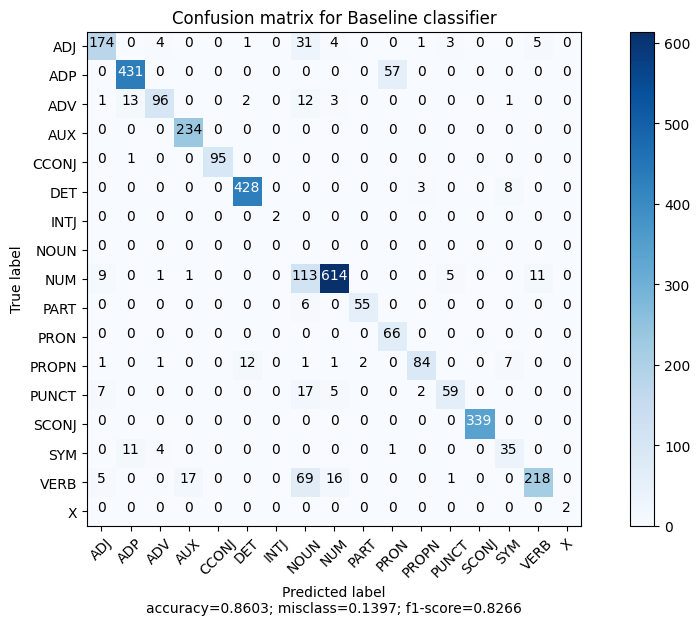

In [36]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

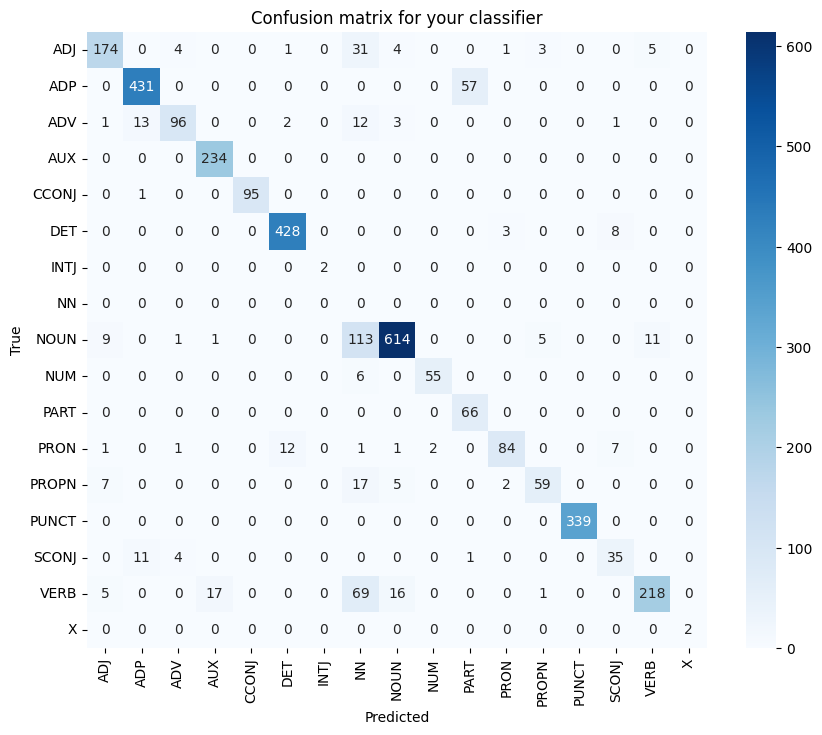

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)

# Assuming classes is a list of class labels
classes = ["ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NN", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "VERB", "X"]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix for your classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


$$LOGREG_l$$

In [38]:
X_train, y_train, X_val, y_val, X_test, y_test = vectorize(train_sentences, val_sentences, test_sentences,
                                                           window=1, method='embs')

Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43503, 900)
Validation shape: (2722, 900)
Test shape: (3408, 900)
Found 1476 unknown words in train set 78 unknown words in validation set and 50 unknown words in test set


In [39]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, method='classical')

Classical method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43503, 28706)
Validation shape: (2722, 28706)
Test shape: (3408, 28706)


In [40]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, window=2, method='boosted')

Combined Classical - Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43503, 30206)
Validation shape: (2722, 30206)
Test shape: (3408, 30206)
Found 2396 unknown words in train set 123 unknown words in validation set and 79 unknown words in test set


## Hyper-paramater Tuning

In [41]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [42]:
X_train.shape

(46225, 30206)

In [43]:
len(y_train)

46225

In [44]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [45]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# from sklearn.metrics import UndefinedMetricWarning
# import warnings

# warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)


# Ignore ConvergenceWarning from LogisticRegression
warnings.filterwarnings("ignore", category=ConvergenceWarning)

logregr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
# skf = StratifiedKFold(n_splits=5, random_state=1)
logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

# Estimator: LogisticRegression(random_state=13, solver='liblinear')
# Tuning hyper-parameters for accuracy


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters set found on development set:
{'C': 2}

Grid scores on development set:
0.880 (+/-0.075) for {'C': 0.1}
0.916 (+/-0.055) for {'C': 1}
0.928 (+/-0.056) for {'C': 2}
0.926 (+/-0.055) for {'C': 3}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.3333    1.0000    0.5000         1
         ADP     1.0000    1.0000    1.0000         8
         ADV     0.0000    0.0000    0.0000         1
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     1.0000    1.0000    1.0000         3
         DET     1.0000    1.0000    1.0000         7
        NOUN     0.8571    0.9231    0.8889        13
         NUM     0.0000    0.0000    0.0000         1
       PROPN     1.0000    1.0000    1.0000         1
       PUNCT     0.8333    1.0000    0.9091         5
       SCONJ     0.0000    0.0000    0.0000         2
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/

Best parameters set found on development set:
{'C': 2}

Grid scores on development set:
0.722 (+/-0.145) for {'C': 0.1}
0.810 (+/-0.087) for {'C': 1}
0.840 (+/-0.119) for {'C': 2}
0.836 (+/-0.110) for {'C': 3}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.3333    1.0000    0.5000         1
         ADP     1.0000    1.0000    1.0000         8
         ADV     0.0000    0.0000    0.0000         1
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     1.0000    1.0000    1.0000         3
         DET     1.0000    1.0000    1.0000         7
        NOUN     0.8571    0.9231    0.8889        13
         NUM     0.0000    0.0000    0.0000         1
       PROPN     1.0000    1.0000    1.0000         1
       PUNCT     0.8333    1.0000    0.9091         5
       SCONJ     0.0000    0.0000    0.0000         2
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TRAINING

In [46]:
# t_ini = datetime.datetime.now()
# print('Training...')
# clf = LogisticRegression(C=1, solver='liblinear', multi_class='auto', random_state=13)
# clf.fit(X_train, y_train)
# t_fin = datetime.datetime.now()
# print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

## Model Evaluation

In [47]:
# y_pred = clf.predict(X_test)

In [48]:
# print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
# print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

## Using a FF Neural Network

In [49]:
X_train, y_train, X_val, y_val, X_test, y_test = vectorize(train_sentences, val_sentences, test_sentences, window=1, method='embs')

Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43503, 900)
Validation shape: (2722, 900)
Test shape: (3408, 900)
Found 1476 unknown words in train set 78 unknown words in validation set and 50 unknown words in test set


In [50]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, method='classical')

Classical method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43503, 28706)
Validation shape: (2722, 28706)
Test shape: (3408, 28706)


In [51]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences, window=2, method='boosted')

Combined Classical - Embeddings window method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (43503, 30206)
Validation shape: (2722, 30206)
Test shape: (3408, 30206)
Found 2396 unknown words in train set 123 unknown words in validation set and 79 unknown words in test set


#### 1-hot encoding of labels

In [52]:
classes = sorted(list(set(y_train)))

In [53]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

print(y_train.shape)

(43503, 17)


In [54]:
# Class to compute f1, precision and recall after each epoch
from keras.callbacks import Callback

class mymetrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):

        if self.validation_data is None:
            print("Validation data is not available. Skipping metrics calculation.")
            return

        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        #y_test.argmax(axis=1), y_pred.argmax(axis=1)

        val_targ=val_targ.argmax(axis=1)
        val_predict=val_predict.argmax(axis=1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(' — val_precision: %f — val_recall: %f — val_f1 %f' %(_val_precision, _val_recall, _val_f1))
        return


# class MyMetrics(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if self.validation_data is None:
#             print("Validation data is not available. Skipping metrics calculation.")
#             return

#         val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
#         val_targ = self.validation_data[1]

#         # Rest of your code for metrics calculation
#         # ...

# # ... (the rest of your code remains unchanged)

# history = model.fit(X_train, y_train,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     shuffle=True,
#                     validation_data=(X_val, y_val),
#                     verbose=1,
#                     callbacks=[cp, tb, early_stopping, MyMetrics()])


In [55]:
mymetrics = mymetrics()

### Model Training

In [56]:
from keras import regularizers
from keras.layers import LeakyReLU
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam


# model = Sequential()
# Dense(200) is a fully-connected layer with 200 hidden units.
# In the first layer, we specify the input data shape

# model.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))
# model.add(Dense(y_train.shape[1], activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


model = Sequential()
model.add(Dense(200, activation=LeakyReLU(alpha=0.1), input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               6041400   
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                12864     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

### Model Tuning

In [57]:
from sklearn.metrics import roc_auc_score
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# # Assuming y_test is one-hot encoded
# # Convert one-hot encoded labels back to class indices
# y_true = np.argmax(y_test, axis=1)

# # Predict probabilities for the test set
# y_pred_prob = model.predict(X_test)

# # Initialize an array to store AUC scores for each class
# class_auc_scores = []

# # Calculate AUC score for each class
# for i in range(y_test.shape[1]):
#     auc_score_class_i = roc_auc_score(y_true == i, y_pred_prob[:, i])
#     class_auc_scores.append(auc_score_class_i)

# # Print AUC scores for each class
# for i, auc_score_class_i in enumerate(class_auc_scores):
#     print(f"AUC Score for Class {i}: {auc_score_class_i}")

# # Optionally, you can calculate the average AUC across all classes
# average_auc_score = np.mean(class_auc_scores)
# print("Average AUC Score:", average_auc_score)

nb_epoch = 30
batch_size = 128

t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="tagger.h5",
                     monitor='val_acc',
                     save_best_only=True,
                     verbose=1)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5)

history = model.fit(X_train, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[cp, tb, early_stopping, mymetrics])

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Epoch 1/30
  4/340 [..............................] - ETA: 7s - loss: 7.2071 - accuracy: 0.1406   

337/340 [============================>.] - ETA: 0s - loss: 1.5913 - accuracy: 0.8736

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 14s 20ms/step - loss: 1.5871 - accuracy: 0.8738 - val_loss: 1.2657 - val_accuracy: 0.9181
Epoch 2/30
337/340 [============================>.] - ETA: 0s - loss: 0.9218 - accuracy: 0.9182

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.9220 - accuracy: 0.9181 - val_loss: 0.8935 - val_accuracy: 0.9063
Epoch 3/30
337/340 [============================>.] - ETA: 0s - loss: 0.8402 - accuracy: 0.9216

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.8402 - accuracy: 0.9215 - val_loss: 0.7964 - val_accuracy: 0.9254
Epoch 4/30
338/340 [============================>.] - ETA: 0s - loss: 0.8177 - accuracy: 0.9213

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 6s 17ms/step - loss: 0.8173 - accuracy: 0.9213 - val_loss: 0.7701 - val_accuracy: 0.9284
Epoch 5/30
340/340 [==============================] - ETA: 0s - loss: 0.8042 - accuracy: 0.9223

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.8042 - accuracy: 0.9223 - val_loss: 0.7857 - val_accuracy: 0.9206
Epoch 6/30
339/340 [============================>.] - ETA: 0s - loss: 0.7990 - accuracy: 0.9239

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 16ms/step - loss: 0.7990 - accuracy: 0.9239 - val_loss: 0.8215 - val_accuracy: 0.9240
Epoch 7/30
340/340 [==============================] - ETA: 0s - loss: 0.8068 - accuracy: 0.9212

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 16ms/step - loss: 0.8068 - accuracy: 0.9212 - val_loss: 0.7883 - val_accuracy: 0.9148
Epoch 8/30
339/340 [============================>.] - ETA: 0s - loss: 0.7799 - accuracy: 0.9235

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 6s 17ms/step - loss: 0.7797 - accuracy: 0.9237 - val_loss: 0.7464 - val_accuracy: 0.9269
Epoch 9/30
338/340 [============================>.] - ETA: 0s - loss: 0.7818 - accuracy: 0.9228

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7821 - accuracy: 0.9227 - val_loss: 0.7627 - val_accuracy: 0.9295
Epoch 10/30
340/340 [==============================] - ETA: 0s - loss: 0.7764 - accuracy: 0.9241

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7764 - accuracy: 0.9241 - val_loss: 0.7332 - val_accuracy: 0.9284
Epoch 11/30
340/340 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.9243

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7605 - accuracy: 0.9243 - val_loss: 0.7228 - val_accuracy: 0.9247
Epoch 12/30
337/340 [============================>.] - ETA: 0s - loss: 0.7654 - accuracy: 0.9235

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 6s 17ms/step - loss: 0.7657 - accuracy: 0.9235 - val_loss: 0.7806 - val_accuracy: 0.9225
Epoch 13/30
340/340 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.9269

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7460 - accuracy: 0.9269 - val_loss: 0.8031 - val_accuracy: 0.8979
Epoch 14/30
339/340 [============================>.] - ETA: 0s - loss: 0.7429 - accuracy: 0.9251

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7433 - accuracy: 0.9249 - val_loss: 0.7341 - val_accuracy: 0.9306
Epoch 15/30
339/340 [============================>.] - ETA: 0s - loss: 0.7365 - accuracy: 0.9264

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7365 - accuracy: 0.9264 - val_loss: 0.6990 - val_accuracy: 0.9251
Epoch 16/30
340/340 [==============================] - ETA: 0s - loss: 0.7258 - accuracy: 0.9260

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 6s 16ms/step - loss: 0.7258 - accuracy: 0.9260 - val_loss: 0.7061 - val_accuracy: 0.9195
Epoch 17/30
338/340 [============================>.] - ETA: 0s - loss: 0.7316 - accuracy: 0.9244

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7310 - accuracy: 0.9245 - val_loss: 0.6754 - val_accuracy: 0.9280
Epoch 18/30
337/340 [============================>.] - ETA: 0s - loss: 0.7244 - accuracy: 0.9244

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 6s 16ms/step - loss: 0.7242 - accuracy: 0.9243 - val_loss: 0.7038 - val_accuracy: 0.9284
Epoch 19/30
339/340 [============================>.] - ETA: 0s - loss: 0.7077 - accuracy: 0.9263

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 16ms/step - loss: 0.7085 - accuracy: 0.9261 - val_loss: 0.6703 - val_accuracy: 0.9328
Epoch 20/30
337/340 [============================>.] - ETA: 0s - loss: 0.7131 - accuracy: 0.9243

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7126 - accuracy: 0.9244 - val_loss: 0.6791 - val_accuracy: 0.9251
Epoch 21/30
338/340 [============================>.] - ETA: 0s - loss: 0.7029 - accuracy: 0.9267

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 6s 17ms/step - loss: 0.7033 - accuracy: 0.9266 - val_loss: 0.7019 - val_accuracy: 0.9221
Epoch 22/30
337/340 [============================>.] - ETA: 0s - loss: 0.7033 - accuracy: 0.9252

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.7034 - accuracy: 0.9252 - val_loss: 0.7286 - val_accuracy: 0.9181
Epoch 23/30
338/340 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.9269

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.6896 - accuracy: 0.9268 - val_loss: 0.6908 - val_accuracy: 0.9247
Epoch 24/30
337/340 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.9279

Validation data is not available. Skipping metrics calculation.
340/340 [==============================] - 5s 15ms/step - loss: 0.6883 - accuracy: 0.9279 - val_loss: 0.6855 - val_accuracy: 0.9276
Training completed in 180.814422 seconds


### Model Fitting

In [58]:
# Find the key corresponding to validation accuracy
val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

# Find the index of the maximum validation accuracy
best_epoch = history.history[val_acc_key].index(max(history.history[val_acc_key]))

# Print the best epoch index
print('The best epoch in serial order is: ', best_epoch)


The best epoch in serial order is:  18


In [59]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(43503, 30206)
(2722, 30206)
(43503, 17)
(2722, 17)


In [60]:
X_train = vstack((X_train, X_val)).tocsr()
y_train = np.append(y_train, y_val, axis=0)

In [61]:
y_pred = model.predict(X_test)

107/107 [==============================] - 10s 4ms/step


## Re-instantiation

##### Added L2 Regularization

In [ ]:
from keras import regularizers
from keras.layers import LeakyReLU

model = Sequential()
model.add(Dense(200, activation=LeakyReLU(alpha=0.1), input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# model.add(Dense(200, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.5))

# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.4))

# activation=LeakyReLU(alpha=0.1)


#### Learning Rate Schedule (LR)

In [69]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [70]:
model.fit(X_train, y_train,
                    epochs=best_epoch+1,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr]
                   )
# model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[reduce_lr])



Epoch 1/19
362/362 [==============================] - 6s 17ms/step - loss: 0.6807 - accuracy: 0.9262 - val_loss: 0.6352 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 2/19
362/362 [==============================] - 5s 15ms/step - loss: 0.6837 - accuracy: 0.9263 - val_loss: 0.5997 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 3/19
362/362 [==============================] - 6s 15ms/step - loss: 0.6755 - accuracy: 0.9263 - val_loss: 0.5847 - val_accuracy: 0.9486 - lr: 0.0010
Epoch 4/19
362/362 [==============================] - 5s 15ms/step - loss: 0.6777 - accuracy: 0.9260 - val_loss: 0.6080 - val_accuracy: 0.9438 - lr: 0.0010
Epoch 5/19
362/362 [==============================] - 6s 16ms/step - loss: 0.6646 - accuracy: 0.9258 - val_loss: 0.5872 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 6/19
362/362 [==============================] - 6s 16ms/step - loss: 0.6659 - accuracy: 0.9267 - val_loss: 0.5941 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 7/19
362/362 [==============================] - 6s 15ms/st

## Evaluation

In [71]:
model.save('tagger_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
scores = model.evaluate(X_test, y_test, verbose=1)

107/107 [==============================] - 1s 6ms/step - loss: 0.5566 - accuracy: 0.9545


In [73]:
y_pred = model.predict(X_test, batch_size=1, verbose=1)

3408/3408 [==============================] - 10s 3ms/step


In [81]:
print("Accuracy: {0:.4f}".format(scores[1]))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')))


Accuracy: 0.9545
f1-macro score: 0.8767


###### AUC Metric

In [85]:
from sklearn.metrics import roc_auc_score
# Calculate the AUC score
auc_score = roc_auc_score(y_val, y_pred)

# Print the AUC score
print("AUC Score:", auc_score)

ValueError: ignored

### Classification Report

In [67]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.8628    0.8744    0.8686       223
           1     0.9596    0.9734    0.9664       488
           2     0.9386    0.8359    0.8843       128
           3     0.9955    0.9530    0.9738       234
           4     0.9794    0.9896    0.9845        96
           5     0.9954    0.9772    0.9862       439
           6     0.0000    0.0000    0.0000         2
           7     0.9678    0.9576    0.9627       754
           8     0.9683    1.0000    0.9839        61
           9     0.8919    1.0000    0.9429        66
          10     0.9388    0.8440    0.8889       109
          11     0.8810    0.8222    0.8506        90
          12     1.0000    1.0000    1.0000       339
          13     0.6406    0.8039    0.7130        51
          15     0.8977    0.9693    0.9322       326
          16     1.0000    0.5000    0.6667         2

    accuracy                         0.9495      3408
   macro avg     0.8698   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               6041400   
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                12864     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

#### Common Mistakes

In [ ]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test.argmax(axis=1)
    if y_pred.argmax(axis=1)[i]!=y_test.argmax(axis=1)[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

## Learning Curves

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(history.history.keys())

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
name='MLP'

In [ ]:
plot_confusion_matrix(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout
from itertools import cycle

# Assuming X_train, y_train are your training data and labels
# X_test, y_test are your test data and labels

# Binarize the labels
y_train_bin = label_binarize(y_train, classes=list(range(y_train.shape[1])))
y_test_bin = label_binarize(y_test, classes=list(range(y_test.shape[1])))

# Get the number of classes
num_classes = y_train_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])  # Add more colors if needed

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Predicting Capabilities

In [86]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [87]:
test_sentence = nltk.word_tokenize('Word embeddings offer a compact representation of words along with their associated meanings in a dense format.'.lower())

In [88]:
X_test_sentence = transform_test_sentence(test_sentence, window=1)

In [89]:
X_embs = [x[1][0] for x in X_test_sentence]
X_embs = np.asarray(X_embs)
X_test_sentence = X_embs

In [92]:
# pred = model.predict_classes(X_test_sentence, batch_size=1, verbose=1)
# Use predict method to get raw probabilities
pred_probabilities = model.predict(X_test_sentence, batch_size=1, verbose=1)

ValueError: ignored

In [ ]:
print('Here is what our MLP tagger predicts for the test sentence:\n',list(zip(test_sentence, le.inverse_transform(pred))))